In [1]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [2]:
RUCIO_ACCOUNT="nihartma"

In [3]:
import time
import os
from pathlib import Path
import json
import gc
import pyarrow.parquet as pq
import fsspec
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import vector
from tqdm.auto import tqdm
from physlite_experiments.physlite_events import Factory
from physlite_experiments.analysis_example import get_obj_sel
from utils_new import setup_rucio_and_proxy, get_signed_url, SetupRucioAndProxyWorker
from rucio.client import Client

In [4]:
x509_path = Path("x509up")
if not x509_path.exists():
    x509_data = upload.data[-1]
    with x509_path.open("wb") as f:
        f.write(x509_data)
else:
    with x509_path.open("rb") as f:
        x509_data = f.read()

In [5]:
setup_rucio_and_proxy(x509_data, rucio_account=RUCIO_ACCOUNT)

In [6]:
rucio_client = Client(ca_cert=False)

In [7]:
files = list(rucio_client.list_files("user.nihartma", "user.nihartma.physlite_to_parquet_gcp_100p_2021-11-17_1605_output.parquet"))

/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-server-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-auth-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-server-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warni

In [8]:
# Total TiB
sum(file["bytes"] for file in files) / 1024 ** 4

63.21627996741336

In [9]:
files[0]["bytes"] / 1024 ** 3

12.639190495945513

In [10]:
url = get_signed_url(files[0]["scope"], files[0]["name"], ca_cert=False)

/srv/conda/envs/notebook/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voatlasrucio-server-prod.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [11]:
class MonitoredFile:
    """
    Monitor accessed ranges
    """
    
    def __init__(self, f):
        self.f = f
        self.read_ranges = []
    
    def read(self, n):
        self.read_ranges.append((time.time_ns(), self.f.tell(), n))
        return self.f.read(n)
    
    def seek(self, *args):
        return self.f.seek(*args)
    
    def tell(self):
        return self.f.tell()
    
    @property
    def closed(self):
        return self.f.closed

In [12]:
with fsspec.open(url, cache_type="none") as f:
    f = MonitoredFile(f)
    print(pq.ParquetFile(f).num_row_groups)
    print(f.read_ranges)

64
[(1648561347464135244, 13571161921, 65536), (1648561347617532257, 13568046847, 3180602)]


In [13]:
def dunder_to_dot(events, collection):
    for k in events[collection].fields:
        if "__" in k:
            events[collection, k.replace("__", ".")] = events[collection, k]
    return events

In [14]:
def run_analysis(events):
    events = get_obj_sel(events)
    info = {
        collection: {
            flag : ak.count_nonzero(events[collection][flag])
            for flag in ["baseline", "passOR", "signal"]
        } for collection in ["Electrons", "Muons", "Jets"]
    }
    events["Muons", "m"] = 105.6583715 # muon mass was not stored yet
    leptons = ak.packed(
        events[
            ["Electrons", "Muons"],
            ["pt", "eta", "phi", "passOR", "signal", "baseline", "m"]
        ]
    )
    return {"info": info, "leptons": ak.to_arrow(leptons)}

In [15]:
%%time
with fsspec.open(url,
                 cache_type="none"
                ) as f:
    f = MonitoredFile(f)
    events = Factory.from_parquet(f, row_groups=0).events
    events = dunder_to_dot(events, "Muons")
    res = run_analysis(events)
    read_ranges = np.array(f.read_ranges)

/srv/conda/envs/notebook/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


CPU times: user 1.81 s, sys: 205 ms, total: 2.02 s
Wall time: 6.47 s


In [16]:
def plot_io(read_ranges):
    h, e = np.histogram(read_ranges[:, 0], weights=read_ranges[:, 2], bins=10)
    plt.stairs(h / (e[1:] - e[:-1]) * 1e9, e.astype("datetime64[ns]"))
    plt.xticks(rotation=45);
    plt.ylabel("bytes per second")

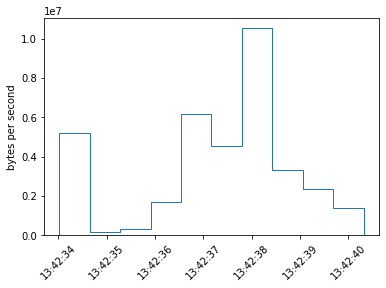

In [17]:
plot_io(read_ranges)

In [18]:
def get_num_row_groups(file):
    from utils_new import get_signed_url
    with fsspec.open(get_signed_url(file["scope"], file["name"], ca_cert=False), cache_type="none") as f:
        return pq.ParquetFile(f).num_row_groups

Start cluster with [`manage_cluster.ipynb`](manage_cluster.ipynb)

In [19]:
from dask_gateway import Gateway
gateway = Gateway()
clusters = gateway.list_clusters()
clusters

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


[ClusterReport<name=default.4f094720562241ea879715f47dd12f0d, status=RUNNING>]

In [20]:
cluster = gateway.connect(clusters[0].name)
client = cluster.get_client()

In [21]:
cluster

In [72]:
from distributed.diagnostics.plugin import UploadFile
from distributed import progress
client.register_worker_plugin(UploadFile("utils_new.py"))
client.register_worker_plugin(SetupRucioAndProxyWorker(os.environ["X509_USER_PROXY"], rucio_account=RUCIO_ACCOUNT))

{'tls://10.64.1.2:40831': {'status': 'OK'},
 'tls://10.64.1.3:40391': {'status': 'OK'},
 'tls://10.64.1.4:40187': {'status': 'OK'},
 'tls://10.64.1.5:34193': {'status': 'OK'},
 'tls://10.64.1.6:36641': {'status': 'OK'},
 'tls://10.64.1.7:34879': {'status': 'OK'},
 'tls://10.64.1.8:45909': {'status': 'OK'},
 'tls://10.64.2.2:40637': {'status': 'OK'},
 'tls://10.64.2.3:46771': {'status': 'OK'},
 'tls://10.64.3.2:36877': {'status': 'OK'},
 'tls://10.64.3.3:35497': {'status': 'OK'},
 'tls://10.64.3.4:46249': {'status': 'OK'},
 'tls://10.64.3.5:43353': {'status': 'OK'},
 'tls://10.64.3.6:37611': {'status': 'OK'},
 'tls://10.64.3.7:33757': {'status': 'OK'},
 'tls://10.64.3.8:46745': {'status': 'OK'}}

In [23]:
fut = client.submit(get_num_row_groups, files[0])

In [24]:
fut.result()

64

In [29]:
def split(l, n):
    "split list into chunks roughly of length n"
    import math
    npart = math.ceil(len(l) / n)
    return [list(i) for i in np.array_split(np.array(l, dtype=object), npart)]

In [30]:
if not Path("files.json").exists():
    futs = client.map(get_num_row_groups, files)
    num_row_groups = client.gather(futs)
    for file, file_rg in zip(files, num_row_groups):
        file["num_row_groups"] = file_rg
    with open("files.json", "w") as f:
        json.dump(files, f)

In [31]:
with open("files.json") as f:
    files = json.load(f)

Parallelize over files first, row groups second

In [32]:
job_params = []
for file in files:
    for i in split(list(range(file["num_row_groups"])), 5):
        job_params.append((file, i))
job_params = sorted(job_params, key=lambda x: x[1][0])

In [33]:
len(job_params)

63873

In [34]:
def job_url(file):
    from utils_new import get_signed_url
    return get_signed_url(file["scope"], file["name"], ca_cert=False)

In [35]:
def merge_info(infos):
    info = {
        collection: {
            flag: 0
            for flag in ["baseline", "passOR", "signal"]
        } for collection in ["Electrons", "Muons", "Jets"]
    }
    for result in infos:
        for collection, flags in result.items():
            for flag, count in flags.items():
                info[collection][flag] += count
    return info

In [36]:
def job(url, row_groups):
    start = time.time_ns()
    with fsspec.open(url, cache_type="none") as f:
        f = MonitoredFile(f)
        infos = []
        leptons = []
        nevents = 0
        for row_group in row_groups:
            events = Factory.from_parquet(f, row_groups=row_group).events
            events = dunder_to_dot(events, "Muons")
            res = run_analysis(events)
            infos.append(res["info"])
            leptons.append(ak.from_arrow(res["leptons"]))
            nevents += len(events)
            del events
            gc.collect()
    stop = time.time_ns()
    out = {"info": {}, "leptons": ak.to_arrow(ak.concatenate(leptons))}
    out["counts"] = merge_info(infos)
    out["info"]["start"] = start
    out["info"]["stop"] = stop
    out["info"]["time"] = stop - start
    out["info"]["read_ranges"] = np.array(f.read_ranges)
    out["info"]["nevents"] = nevents
    return out

In [37]:
fut_url = client.submit(job_url, files[0])
fut = client.submit(job, fut_url, [0, 1])

In [38]:
res = fut.result()
leptons = ak.from_arrow(res["leptons"])
info = res["info"]

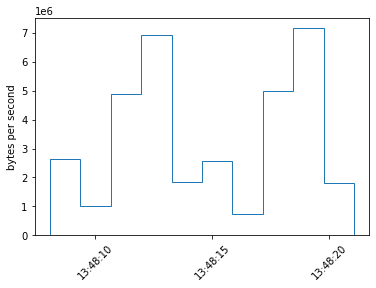

In [39]:
plot_io(info["read_ranges"])

In [40]:
info["nevents"] / info["time"] * 1e9

9661.415735850816

In [41]:
leptons.Electrons.pt

<Array [[], [], [], [], ... [], [], [4.14e+04]] type='130576 * option[var * floa...'>

In [42]:
def job_combined(file, row_groups):
    url = job_url(file)
    return job(url, row_groups)

old variant: url job as dependency:
```python
futs = []
futs_url = {}
for file, row_group in job_params[:len(job_params)]:
#for file, row_group in job_params[:10]:
    if file["name"] not in futs_url:
        futs_url[file["name"]] = client.submit(job_url, file)
    fut_url = futs_url[file["name"]]
    futs.append(client.submit(job, fut_url, row_group))
```

alternative: combined where each job fetches url (better for huge clusters?)

In [73]:
futs = []
for file, row_group in job_params[:len(job_params)]:
#for file, row_group in job_params[:32]:
    futs.append(client.submit(job_combined, file, row_group))

In [45]:
[fut for fut in futs if not fut.status in ["pending", "finished"]]

[]

In [175]:
unfinished = [fut for fut in futs if not fut.status in ["finished"]]

In [176]:
finished = [fut for fut in futs if fut.status == "finished"]

In [177]:
len(finished)

63873

In [178]:
len(unfinished)

0

In [179]:
#client.cancel(unfinished)

In [180]:
read_ranges_fut = client.map(lambda x: x["info"]["read_ranges"], finished)

In [184]:
[fut for fut in read_ranges_fut if fut.status != "finished"]

[]

In [181]:
#[fut for fut in read_ranges_fut if fut.status == "finished"]

In [185]:
read_ranges = np.concatenate(client.gather([fut for fut in read_ranges_fut if fut.status == "finished"]))

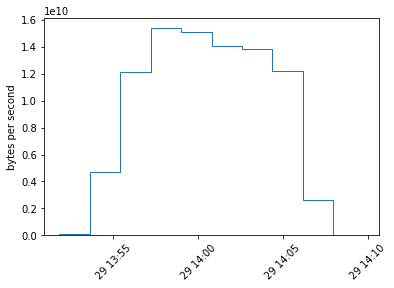

In [187]:
plot_io(read_ranges)
plt.savefig("bytes_per_second_parquet_100p_4kcores.pdf")

In [188]:
len(files)

5003

In [189]:
events_stat_fut = client.map(lambda x: (x["info"]["time"], x["info"]["stop"], x["info"]["nevents"]), finished)

In [190]:
[fut for fut in events_stat_fut if fut.status != "finished"]

[]

In [191]:
#events_stat = np.array(client.gather(client.map(lambda x: (x["info"]["time"], x["info"]["nevents"]), futs)))
events_stat = np.array(client.gather([fut for fut in events_stat_fut if fut.status == "finished"]))

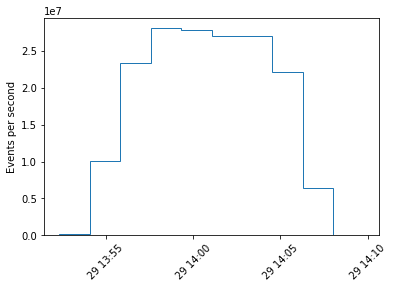

In [206]:
# maybe sth wrong here ...
h, e = np.histogram(events_stat[:, 1], weights=events_stat[:, 2], bins=10)
plt.stairs(h / (e[1:] - e[:-1]) * 1e9, e.astype("datetime64[ns]"))
plt.xticks(rotation=45);
plt.ylabel("Events per second")
plt.savefig("events_pers_second_parquet_100p_4kcores.pdf")

In [193]:
(events_stat[:, 2] / events_stat[:, 0] * 1e9).mean()

6633.973204906122

In [194]:
events_stat[:, 2].sum() / (events_stat[:, 1].max() - events_stat[:, 1].min()) * 1e9

17221879.08301719

In [195]:
def dilepton_mass(leptons):
    import vector
    vector.register_awkward()
    leptons = ak.from_arrow(leptons)
    leptons = ak.concatenate([leptons.Electrons, leptons.Muons], axis=1)
    leptons["p4"] = vector.awk(leptons[["pt", "eta", "phi", "m"]])
    lep1, lep2 = ak.unzip(ak.combinations(leptons.p4, 2))
    return ak.flatten((lep1 + lep2).m).to_numpy()

In [196]:
dilepton_mass(futs[0].result()["leptons"])

array([ 3134.70868481,  6957.97388927,  3131.97635851, ...,
       18232.78574739,  3030.84950198,  8177.91152904])

In [197]:
lepton_futs = client.map(lambda res: res["leptons"], finished)

In [198]:
mass_futs = client.map(dilepton_mass, lepton_futs)

In [199]:
bins = np.geomspace(300, 150000, 500)

In [200]:
def histogram(mass):
    hist, _ = np.histogram(mass, bins=bins)
    return hist

In [201]:
mass_futs[0].result()

array([ 3134.70868481,  6957.97388927,  3131.97635851, ...,
       18232.78574739,  3030.84950198,  8177.91152904])

In [202]:
[fut for fut in mass_futs if fut.status != "finished"]

[]

In [203]:
hist = sum(client.gather(client.map(histogram, mass_futs)))

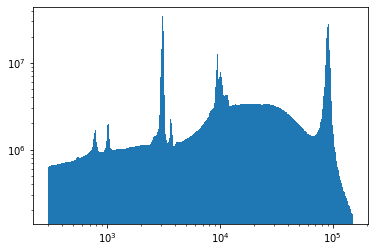

In [204]:
# still the plot for 10%
plt.stairs(hist, bins, fill=True)
plt.xscale("log")
plt.yscale("log")

In [205]:
cluster.shutdown()